# ПЕТ ПРОЕКТ
## Определение числа "рукопожатий" между Лемтюговым <br>
## и остальными игроками КХЛ ("число Лемтюгова")

Цель: Определить через сколько игроков Николай Лемтюгов связан со всем остальными игроками КХЛ

Данные об игроках получены с сайта eliteprospects.com

Исследование пройдет через следующие этапы:<br>
1. Подготовка данных<br>
1.1. Загрузка данных<br>
1.2. Знакомство с данными<br>
1.3. Обработка данных(поиск дублей, преобразование данных столбцов в правильный<br>
     формат, создание дополнительных столбцов)<br>
2. Расчет числа Лемтюгова<br>
3. Выводы

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import collections

In [ ]:
pd.options.display.max_columns = None

### Загрузка данных

Прочитаем данные из файлов:

In [ ]:
'''
pl_d = pd.read_csv('players_data.csv')
pl_p_d = pd.read_csv('players_personal_data.csv')
pl_stat = pd.read_csv('players_stats.csv')
pl_trans = pd.read_csv('transfers.csv')
'''

"\npl_d = pd.read_csv('players_data.csv')\npl_p_d = pd.read_csv('players_personal_data.csv')\npl_stat = pd.read_csv('players_stats.csv')\npl_trans = pd.read_csv('transfers.csv')\n"

In [ ]:
#Код ревьюера - загружаю датасеты по общедоступным ссылкам
pl_d = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/players_data.csv')
pl_trans = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/transfers.csv')
pl_p_d = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/players_personal_data.csv')
pl_stat = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/players_stats.csv')

Посмотрим, то получилось:

In [ ]:
pl_d.head()

,Team,Season,Player,Player_number,Position,Captain,Born,Birthplace,Age,Height,Weight,Stick,Player_link
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,https://www.eliteprospects.com/player/19555/se...
1,Salavat Yulaev Ufa,2008-2009,Rafael Khakimov,31,G,NaN,1990,"Ufa, RUS",33.0,180,78,L,https://www.eliteprospects.com/player/47547/ra...
2,Salavat Yulaev Ufa,2008-2009,Vadim Tarasov,1,G,NaN,1976,"Ust-Kamenogorsk, KAZ",46.0,183,84,L,https://www.eliteprospects.com/player/11990/va...
3,Salavat Yulaev Ufa,2008-2009,Alexander Yeryomenko,30,G,NaN,1980,"Moskva, RUS",43.0,180,78,L,https://www.eliteprospects.com/player/12286/al...
4,Salavat Yulaev Ufa,2008-2009,Miroslav Blatak,23,D,NaN,1982,"Zlin, CZE",41.0,180,78,L,https://www.eliteprospects.com/player/8421/mir...


сделаем все заголовки во всех таблицах строчними буквами:

In [ ]:
tab_names = [pl_d, pl_p_d, pl_trans, pl_stat]
for tab in tab_names:
    tab.columns = tab.columns.str.lower()

Посмотрим на датасет с персональными данными хоккеистов:

In [ ]:
pl_p_d.head()

,player_name,date_of_birth,position,age,place_of_birth,nation,grip,youth_team,height_cm,height_ft,weight_kg,weight_lbs,awards,player_link
0,Sergei Belov,1982-09-27 00:00:00,G,40,"St. Petersburg, RUS",Russia,L,SKA St. Petersburg,180,"5'11""",78,172 lbs,"{""2009-2010"": [""Russia2 Silver Medal""], ""2013-...",https://www.eliteprospects.com/player/19555/se...
1,Rafael Khakimov,1990-04-06 00:00:00,G,33,"Ufa, RUS",Russia,L,Salavat Yulaev Ufa,180,"5'11""",78,172 lbs,"{""2010-2011"": [""MHL All-Star Game"", ""MHL Best ...",https://www.eliteprospects.com/player/47547/ra...
2,Vadim Tarasov,1976-12-31 00:00:00,G,46,"Ust-Kamenogorsk, KAZ",Russia\n \n / \n Kaza...,L,Torpedo Ust-Kamenogorsk,183,"6'0""",84,185 lbs,"{""1998-1999"": [""RSL Best Goaltender""], ""1999-2...",https://www.eliteprospects.com/player/11990/va...
3,Alexander Yeryomenko,1980-04-10 00:00:00,G,43,"Moskva, RUS",Russia,L,Dynamo Moskva,180,"5'11""",78,172 lbs,"{""2004-2005"": [""RSL Champion"", ""World Champion...",https://www.eliteprospects.com/player/12286/al...
4,Miroslav Blatak,1982-05-25 00:00:00,D,41,"Zlin, CZE",Czechia,L,HC Zlin,180,"5'11""",78,172 lbs,"{""2001-2002"": [""Czech Extraliga Bronze Medal"",...",https://www.eliteprospects.com/player/8421/mir...


In [ ]:
pl_p_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599 entries, 0 to 3598
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   player_name     3599 non-null   object
 1   date_of_birth   3599 non-null   object
 2   position        3599 non-null   object
 3   age             3599 non-null   object
 4   place_of_birth  3599 non-null   object
 5   nation          3599 non-null   object
 6   grip            3599 non-null   object
 7   youth_team      3599 non-null   object
 8   height_cm       3599 non-null   int64 
 9   height_ft       3599 non-null   object
 10  weight_kg       3599 non-null   int64 
 11  weight_lbs      3599 non-null   object
 12  awards          3599 non-null   object
 13  player_link     3599 non-null   object
dtypes: int64(2), object(12)
memory usage: 393.8+ KB


Посмотрим на датасет со статистикой играков:

In [ ]:
pl_stat.head()

,unnamed: 0,player_name,season,team,league,player_link,regular_games_played,regular_goals,regular_assists,regular_total_points,regular_penalty_minutes,regular_plus_minus,regular_games_dressed,regular_gaa,regular_saves_percentage,regular_goals_against,regular_saves,regular_shutouts,regular_wlt,regular_toi,postseason_games_played,postseason_goals,postseason_assists,postseason_total_points,postseason_penalty_minutes,postseason_plus_minus,postseason_games_dressed,postseason_gaa,postseason_saves_percentage,postseason_goals_against,postseason_saves,postseason_shutouts,postseason_wlt,postseason_toi
0,0,Sergei Belov,2000-01,SKASt.Petersburg,Russia,https://www.eliteprospects.com/player/19555/se...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,18.00,0.75,6.0,18.0,0.0,0-0-0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sergei Belov,2000-01,SKASt.Petersburg-2,Russia3,https://www.eliteprospects.com/player/19555/se...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sergei Belov,2001-02,SKASt.Petersburg,Russia,https://www.eliteprospects.com/player/19555/se...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9.00,0.70,6.0,14.0,0.0,0-0-0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Sergei Belov,2001-02,SKASt.Petersburg-2,Russia3,https://www.eliteprospects.com/player/19555/se...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Sergei Belov,2001-02,SpartakSt.Petersburg,Russia2,https://www.eliteprospects.com/player/19555/se...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,5.19,NaN,21.0,NaN,0.0,0-1-1,243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на датасет с переходами игроков из клуба в клуб:

In [ ]:
pl_trans.head()

,date,player,player_link,from_team,from_team_link,to_team,to_team_link
0,05/06/2023,Stefan Warg,https://www.eliteprospects.com/player/6870/ste...,HC Sparta Praha,https://www.eliteprospects.com/team/164/hc-spa...,Unknown,NaN
1,05/06/2023,Patrik Romancik,https://www.eliteprospects.com/player/102395/p...,Vlci Zilina,https://www.eliteprospects.com/team/1162/vlci-...,VHK Vsetín,https://www.eliteprospects.com/team/5337/vhk-v...
2,05/06/2023,Paul Stanley,https://www.eliteprospects.com/player/119679/p...,Solihull Barons,https://www.eliteprospects.com/team/1525/solih...,Retired,NaN
3,05/06/2023,Marcus Maynard,https://www.eliteprospects.com/player/122841/m...,Solihull Barons,https://www.eliteprospects.com/team/1525/solih...,Retired,NaN
4,05/06/2023,Sam Hewitt,https://www.eliteprospects.com/player/156284/s...,Solihull Barons,https://www.eliteprospects.com/team/1525/solih...,Retired,NaN


Посмотрим на статистичесике харктеристики датасета с игроками:

In [ ]:
pl_d.describe(include='all')

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_link
count,14332,14332,14332,14332.000000,14332,1037,14332.000000,14271,14234.000000,14332.000000,14332.000000,14332,14332
unique,40,15,3561,NaN,26,2,NaN,840,NaN,NaN,NaN,3,3599
top,Neftekhimik Nizhnekamsk,2016-2017,Vladimir Tkachyov,NaN,D,“A,NaN,"Moskva, RUS",NaN,NaN,NaN,L,https://www.eliteprospects.com/player/19079/ye...
freq,605,1133,21,NaN,4596,677,NaN,1750,NaN,NaN,NaN,10950,19
mean,NaN,NaN,NaN,42.584636,NaN,NaN,1988.930156,NaN,33.545455,184.246232,89.025188,NaN,NaN
std,NaN,NaN,NaN,29.250105,NaN,NaN,6.500345,NaN,6.506822,5.547821,7.705267,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,1958.000000,NaN,17.000000,167.000000,61.000000,NaN,NaN
25%,NaN,NaN,NaN,17.000000,NaN,NaN,1985.000000,NaN,29.000000,180.000000,84.000000,NaN,NaN
50%,NaN,NaN,NaN,36.000000,NaN,NaN,1989.000000,NaN,33.000000,184.000000,89.000000,NaN,NaN
75%,NaN,NaN,NaN,70.000000,NaN,NaN,1994.000000,NaN,38.000000,188.000000,94.000000,NaN,NaN


Посмотрим на стат.характеристики датасета с персональными данными играков:

In [ ]:
pl_p_d.describe(include='all')

,player_name,date_of_birth,position,age,place_of_birth,nation,grip,youth_team,height_cm,height_ft,weight_kg,weight_lbs,awards,player_link
count,3599,3599,3599,3599,3599,3599,3599,3599,3599.000000,3599,3599.000000,3599,3599,3599
unique,3561,2970,26,42,841,119,3,630,NaN,16,NaN,54,2857,3599
top,Dmitri Vorobyov,1990-01-31 00:00:00,D,32,"Moskva, RUS",Russia,L,-,NaN,"6'0""",NaN,194 lbs,{},https://www.eliteprospects.com/player/19555/se...
freq,3,4,1111,197,360,1923,2695,522,NaN,748,NaN,213,585,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.195610,NaN,87.749931,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.556879,NaN,7.853313,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.000000,NaN,61.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,NaN,82.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.000000,NaN,88.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.000000,NaN,93.000000,NaN,NaN,NaN


Посмотрим на ст.характеристики датасета со статистикой по игрокам:

In [ ]:
pl_stat.describe(include='all')

,unnamed: 0,player_name,season,team,league,player_link,regular_games_played,regular_goals,regular_assists,regular_total_points,regular_penalty_minutes,regular_plus_minus,regular_games_dressed,regular_gaa,regular_saves_percentage,regular_goals_against,regular_saves,regular_shutouts,regular_wlt,regular_toi,postseason_games_played,postseason_goals,postseason_assists,postseason_total_points,postseason_penalty_minutes,postseason_plus_minus,postseason_games_dressed,postseason_gaa,postseason_saves_percentage,postseason_goals_against,postseason_saves,postseason_shutouts,postseason_wlt,postseason_toi
count,116669.000000,116669,116669,116669,116384,116669,112832.000000,99535.000000,99475.000000,99474.000000,98700.000000,75753.000000,5959.000000,11179.000000,9981.000000,8305.000000,7546.000000,7921.000000,7639,8177.000000,34757.000000,30915.000000,30910.000000,30905.000000,30851.00000,27145.000000,1834.000000,3375.000000,3048.000000,2658.000000,2412.000000,2571.000000,2486,2671.000000
unique,NaN,3561,67,5087,676,3599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219,NaN
top,NaN,Mikko Lehtonen,2016-17,Russia,KHL,https://www.eliteprospects.com/player/8627/jar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-1-0,NaN
freq,NaN,116,6369,1907,14944,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244,NaN
mean,58514.046191,NaN,NaN,NaN,NaN,NaN,21.468404,4.550269,6.752993,11.303758,17.626363,1.429211,21.167646,2.823991,0.904359,40.406382,431.541744,1.342381,NaN,951.869879,7.303651,1.376775,2.078680,3.455784,6.34041,0.312323,7.497819,3.005313,0.904539,13.569225,153.344942,0.502139,NaN,334.912767
std,33740.263398,NaN,NaN,NaN,NaN,NaN,19.956762,6.747606,9.175241,15.165137,24.744786,8.408091,19.300940,1.884735,0.107306,38.010167,408.596081,1.889079,NaN,892.100579,5.195076,2.061073,2.803061,4.376124,8.85771,3.365736,5.103110,4.215097,0.179170,10.973910,137.152754,0.926635,NaN,301.667169
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,29386.000000,NaN,NaN,NaN,NaN,NaN,5.000000,0.000000,1.000000,1.000000,2.000000,-2.000000,5.000000,2.040000,0.893000,8.000000,82.000000,0.000000,NaN,180.000000,3.000000,0.000000,0.000000,0.000000,0.00000,-2.000000,4.000000,1.990000,0.890000,5.000000,50.000000,0.000000,NaN,117.000000
50%,58553.000000,NaN,NaN,NaN,NaN,NaN,13.000000,2.000000,3.000000,5.000000,8.000000,0.000000,13.000000,2.580000,0.911000,28.000000,291.500000,1.000000,NaN,639.000000,6.000000,1.000000,1.000000,2.000000,4.00000,0.000000,6.000000,2.530000,0.915000,11.000000,113.000000,0.000000,NaN,241.000000
75%,87720.000000,NaN,NaN,NaN,NaN,NaN,38.000000,6.000000,9.000000,16.000000,24.000000,4.000000,39.000000,3.190000,0.926000,65.000000,710.750000,2.000000,NaN,1587.000000,10.000000,2.000000,3.000000,5.000000,8.00000,2.000000,10.000000,3.380000,0.932000,19.000000,216.000000,1.000000,NaN,474.500000


Посмотрим на стат. характеристики датасета по переходам игроков:

In [ ]:
pl_trans.describe(include='all')

,date,player,player_link,from_team,from_team_link,to_team,to_team_link
count,167125,167125,167125,167125,158148,167125,156866
unique,5447,66630,68114,7421,7583,4213,4302
top,15/08/2022,Alexander Johansson,https://www.eliteprospects.com/player/54887/ja...,No team,https://www.eliteprospects.com/team/836/wichit...,Unknown,https://www.eliteprospects.com/team/252/south-...
freq,222,31,27,8815,303,5524,414


### Поиск пропусков

Найдем проруски в датасете pl_d:

In [ ]:
pl_d.isna().sum()




team                 0
season               0
player               0
player_number        0
position             0
captain          13295
born                 0
birthplace          61
age                 98
height               0
weight               0
stick                0
player_link          0
dtype: int64

Пробежимся по столбцам датасета pl_d с пропусками:

In [ ]:
pl_d['captain'].unique()

array([nan, '“C', '“A'], dtype=object)

Оставляем как есть

In [ ]:
pl_d.query('birthplace.isna()')

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_link
133,CSKA Moskva,2008-2009,Ivan Ageyev,45,G,NaN,1990,NaN,33.0,178,73,L,https://www.eliteprospects.com/player/194673/i...
789,Vityaz Chekhov,2008-2009,Andrei Khaikin,42,G,NaN,1988,NaN,35.0,187,78,L,https://www.eliteprospects.com/player/195114/a...
3893,HC Lev Praha,2012-2013,Ondrej Kocian,2,G,NaN,1991,NaN,32.0,178,78,L,https://www.eliteprospects.com/player/129747/o...
7252,Medvescak Zagreb,2015-2016,Maxim Topol,71,D,NaN,1989,NaN,34.0,189,92,L,https://www.eliteprospects.com/player/87930/ma...
7551,Metallurg Novokuznetsk,2015-2016,Yegor Yevstafiev,20,G,NaN,1996,NaN,26.0,177,70,L,https://www.eliteprospects.com/player/288799/y...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,Kunlun Red Star,2021-2022,Pengfei Zhang,11,D,NaN,1998,NaN,25.0,177,67,L,https://www.eliteprospects.com/player/281642/p...
13683,Kunlun Red Star,2021-2022,Xudong Xiang,29,F,NaN,1995,NaN,27.0,175,72,L,https://www.eliteprospects.com/player/182966/x...
13687,Kunlun Red Star,2021-2022,Cheng Zhang,94,F,NaN,1994,NaN,28.0,172,77,R,https://www.eliteprospects.com/player/67628/ch...
14257,Spartak Moskva,2022-2023,Danila Kvartalnov,22,C,NaN,1997,NaN,25.0,188,86,L,https://www.eliteprospects.com/player/265483/d...


Особого значения в этом столбце нет поэтому оставляем как есть

In [ ]:
pl_d.query('age.isna()')

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_link
72,Atlant Mytishchi,2008-2009,Ray Emery,1,G,NaN,1982,"Hamilton, ON, CAN",NaN,188,89,L,https://www.eliteprospects.com/player/9146/ray...
75,Atlant Mytishchi,2008-2009,Mikhail Balandin,39,D,NaN,1980,"Lipetsk, RUS",NaN,189,98,L,https://www.eliteprospects.com/player/19388/mi...
94,Atlant Mytishchi,2008-2009,Igor Korolyov,22,C,NaN,1970,"Moskva, RUS",NaN,187,90,L,https://www.eliteprospects.com/player/18257/ig...
108,Lokomotiv Yaroslavl,2008-2009,Vitali Anikeyenko,57,D,NaN,1987,"Kyiv, UKR",NaN,192,90,R,https://www.eliteprospects.com/player/9587/vit...
117,Lokomotiv Yaroslavl,2008-2009,Gennadi Churilov,21,C,NaN,1987,"Magnitogorsk, RUS",NaN,183,84,L,https://www.eliteprospects.com/player/10486/ge...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8169,Admiral Vladivostok,2016-2017,Samvel Mnatsyan,13,D,NaN,1990,"Omsk, RUS",NaN,188,96,L,https://www.eliteprospects.com/player/43865/sa...
8224,HC Slovan Bratislava,2016-2017,Boris Sádecký,12,C,NaN,1997,"Trencin, SVK",NaN,184,84,L,https://www.eliteprospects.com/player/179158/b...
8336,Neftekhimik Nizhnekamsk,2016-2017,Artyom Chernov,15,LW/RW,NaN,1982,"Novokuznetsk, RUS",NaN,180,94,L,https://www.eliteprospects.com/player/16744/ar...
9560,Admiral Vladivostok,2017-2018,Samvel Mnatsyan,13,D,NaN,1990,"Omsk, RUS",NaN,188,96,L,https://www.eliteprospects.com/player/43865/sa...


Заполним отсутствующие данные разницей между годом рождения и нынешним - 2023:

In [ ]:
pl_d['born'] = pl_d['born'].astype(int)
pl_d['age'] = pl_d['age'].fillna(2023 - pl_d['born'])

In [ ]:
pl_d.query('age.isna()')

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_link


Найдем пропуски в датасете pl_p_d:

In [ ]:
pl_p_d.isna().sum()

player_name       0
date_of_birth     0
position          0
age               0
place_of_birth    0
nation            0
grip              0
youth_team        0
height_cm         0
height_ft         0
weight_kg         0
weight_lbs        0
awards            0
player_link       0
dtype: int64

Пропусков нет

Найдем пропуски в датасете pl_trans:

In [ ]:
pl_trans.isna().sum()

date                  0
player                0
player_link           0
from_team             0
from_team_link     8977
to_team               0
to_team_link      10259
dtype: int64

Здесь пропуски оставляем как есть, так как никаким образом мы их не заполним

Найдем пропуски в датасете pl_stat:

In [ ]:
pl_stat.isna().sum()

unnamed: 0                          0
player_name                         0
season                              0
team                                0
league                            285
player_link                         0
regular_games_played             3837
regular_goals                   17134
regular_assists                 17194
regular_total_points            17195
regular_penalty_minutes         17969
regular_plus_minus              40916
regular_games_dressed          110710
regular_gaa                    105490
regular_saves_percentage       106688
regular_goals_against          108364
regular_saves                  109123
regular_shutouts               108748
regular_wlt                    109030
regular_toi                    108492
postseason_games_played         81912
postseason_goals                85754
postseason_assists              85759
postseason_total_points         85764
postseason_penalty_minutes      85818
postseason_plus_minus           89524
postseason_g

Здесь также оставляем пропуски как есть - просто не у всех игроков присутствуют используемые показатели

### Проверка на дубликаты

Проверим датасеты на явные дубликаты:

In [ ]:
pl_d.duplicated().sum()

0

Дубликатов нет

In [ ]:
pl_p_d.duplicated().sum()

0

Дубликатов нет

In [ ]:
pl_stat.duplicated().sum()

0

Дубликатов нет

In [ ]:
pl_trans.duplicated().sum()

7

Обнаружили 7 дубликатов, будем их удалять:

In [ ]:
pl_trans.drop_duplicates(inplace=True)

Проверим, что их не осталось:

In [ ]:
pl_trans.duplicated().sum()

0

Дубликатов больше нет

### Добавление необходимых столбцов

Напишем функцию для получения уникального номера из ссылки для игроков и команд:

In [ ]:
def get_id(link):
    return int(link.split('/')[4]) if isinstance(link, str) else np.nan

Применим функция для получения уникального идентификатора игрока:

In [ ]:
pl_d['player_id'] = pl_d['player_link'].apply(get_id)

Удалим ненужный столбец со ссылкой на игрока:

In [ ]:
pl_d.drop('player_link', axis=1, inplace=True)

посмотрим, что получилось:

In [ ]:
pl_d

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_id
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555
1,Salavat Yulaev Ufa,2008-2009,Rafael Khakimov,31,G,NaN,1990,"Ufa, RUS",33.0,180,78,L,47547
2,Salavat Yulaev Ufa,2008-2009,Vadim Tarasov,1,G,NaN,1976,"Ust-Kamenogorsk, KAZ",46.0,183,84,L,11990
3,Salavat Yulaev Ufa,2008-2009,Alexander Yeryomenko,30,G,NaN,1980,"Moskva, RUS",43.0,180,78,L,12286
4,Salavat Yulaev Ufa,2008-2009,Miroslav Blatak,23,D,NaN,1982,"Zlin, CZE",41.0,180,78,L,8421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14327,HK Sochi,2022-2023,Nikita Tochitsky,33,C,“C,1991,"St. Petersburg, RUS",31.0,190,86,L,75331
14328,HK Sochi,2022-2023,Artur Tyanulin,13,RW,NaN,1997,"Kazan, RUS",26.0,175,83,R,266824
14329,HK Sochi,2022-2023,Dmitri Utkin,15,C,NaN,2002,"Solnechnogorsk, RUS",20.0,189,82,L,561884
14330,HK Sochi,2022-2023,Tigran Yarulin,18,F,NaN,2003,"Vladivostok, RUS",20.0,189,92,L,652831


Получим уникальные номера игроков в датасете с персональными данными:

In [ ]:
pl_p_d['player_id'] = pl_p_d['player_link'].apply(get_id)

Удаляем уже не нужный столбец:

In [ ]:
pl_p_d.drop('player_link', axis=1, inplace=True)

Получим уникальные номера игроков в датасете со статистикой:

In [ ]:
pl_stat['player_id'] = pl_stat['player_link'].apply(get_id)

Удалаяем ненужный столбец:

In [ ]:
pl_stat.drop('player_link', axis=1, inplace=True)

Получим уникальные номера игроков в датасете с переходами:

In [ ]:
pl_trans['player_id'] = pl_trans['player_link'].apply(get_id)

Получим уникальные номера команд в датасете с переходами игроков:

In [ ]:
pl_trans['from_team_id'] = pl_trans['from_team_link'].apply(get_id)

Получим уникальные номера команд в датасете с переходами игроков:

In [ ]:
pl_trans['to_team_id'] = pl_trans['to_team_link'].apply(get_id)

Удаляем не нужные столбцы:

In [ ]:
pl_trans.drop(['player_link', 'from_team_link', 'to_team_link'], axis=1, inplace=True)

Посмотрим, что получилось:

In [ ]:
pl_trans.head()

,date,player,from_team,to_team,player_id,from_team_id,to_team_id
0,05/06/2023,Stefan Warg,HC Sparta Praha,Unknown,6870,164.0,NaN
1,05/06/2023,Patrik Romancik,Vlci Zilina,VHK Vsetín,102395,1162.0,5337.0
2,05/06/2023,Paul Stanley,Solihull Barons,Retired,119679,1525.0,NaN
3,05/06/2023,Marcus Maynard,Solihull Barons,Retired,122841,1525.0,NaN
4,05/06/2023,Sam Hewitt,Solihull Barons,Retired,156284,1525.0,NaN


In [ ]:
pl_d.head()

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_id
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555
1,Salavat Yulaev Ufa,2008-2009,Rafael Khakimov,31,G,NaN,1990,"Ufa, RUS",33.0,180,78,L,47547
2,Salavat Yulaev Ufa,2008-2009,Vadim Tarasov,1,G,NaN,1976,"Ust-Kamenogorsk, KAZ",46.0,183,84,L,11990
3,Salavat Yulaev Ufa,2008-2009,Alexander Yeryomenko,30,G,NaN,1980,"Moskva, RUS",43.0,180,78,L,12286
4,Salavat Yulaev Ufa,2008-2009,Miroslav Blatak,23,D,NaN,1982,"Zlin, CZE",41.0,180,78,L,8421


In [ ]:
pl_p_d.head()

,player_name,date_of_birth,position,age,place_of_birth,nation,grip,youth_team,height_cm,height_ft,weight_kg,weight_lbs,awards,player_id
0,Sergei Belov,1982-09-27 00:00:00,G,40,"St. Petersburg, RUS",Russia,L,SKA St. Petersburg,180,"5'11""",78,172 lbs,"{""2009-2010"": [""Russia2 Silver Medal""], ""2013-...",19555
1,Rafael Khakimov,1990-04-06 00:00:00,G,33,"Ufa, RUS",Russia,L,Salavat Yulaev Ufa,180,"5'11""",78,172 lbs,"{""2010-2011"": [""MHL All-Star Game"", ""MHL Best ...",47547
2,Vadim Tarasov,1976-12-31 00:00:00,G,46,"Ust-Kamenogorsk, KAZ",Russia\n \n / \n Kaza...,L,Torpedo Ust-Kamenogorsk,183,"6'0""",84,185 lbs,"{""1998-1999"": [""RSL Best Goaltender""], ""1999-2...",11990
3,Alexander Yeryomenko,1980-04-10 00:00:00,G,43,"Moskva, RUS",Russia,L,Dynamo Moskva,180,"5'11""",78,172 lbs,"{""2004-2005"": [""RSL Champion"", ""World Champion...",12286
4,Miroslav Blatak,1982-05-25 00:00:00,D,41,"Zlin, CZE",Czechia,L,HC Zlin,180,"5'11""",78,172 lbs,"{""2001-2002"": [""Czech Extraliga Bronze Medal"",...",8421


удалим столбцы с английскими мерами:

In [ ]:
pl_p_d = pl_p_d.drop(columns=['height_ft', 'weight_lbs'])

Добавим столбы с интервалами по возрасту, весу, росту:

Начнем с возраста:

In [ ]:
pl_p_d['age'].unique()

array(['40', '33', '46', '43', '41', '44', '34', '48', '38', '42', '47',
       '36', '37', '45', '39', '32', '50', '35', '51', '49', '31', '52',
       'Deceased', '53', '30', '54', '59', '65', '58', '29', '28', '27',
       '26', '25', '24', '23', '22', '21', '20', '19', '18', '17'],
      dtype=object)

Есть слово Deceased вместо цифры - требуется заменить на цифру для дальнейшего анализа

In [ ]:
pl_p_d['age'] = pl_p_d['age'].str.replace('Deceased', '-1')

Конвертируем в int:

In [ ]:
pl_p_d['age'] = pl_p_d['age'].astype(int)

Разобъем на интервалы и каждому дадим соответствующее название

In [ ]:
bins = [-1.1,0,19,25,30,35,40,50,60,70]
bin_labels = ['умер','до 20','20-25','26-30','31-35','36-40','41-50','51-60','61-70']
pl_p_d['age_period'] = pd.cut(pl_p_d['age'], bins=bins,labels=bin_labels)

Рост:

In [ ]:
pl_p_d['height_cm'].unique()

array([180, 183, 188, 190, 178, 189, 185, 191, 176, 179, 187, 182, 186,
       177, 192, 174, 184, 197, 181, 193, 175, 173, 196, 194, 167, 195,
       198, 201, 172, 200, 171, 170, 202, 205, 199, 203, 169, 206, 168])

Аномалий, требующих вмещательства нет. Конвертируем в int

In [ ]:
pl_p_d['height_cm'] = pl_p_d['height_cm'].astype(int)

In [ ]:
pl_p_d['height_cm'].agg([min,max])

min    167
max    206
Name: height_cm, dtype: int64

Разобъем на интервалы:

In [ ]:
bins = np.linspace(165, 210, 10)
bin_labels = ['165-170см','170-175см','175-180см','180-185см','185-190см', '190-195см','195-200см','200-205см','205-210см']
pl_p_d['height_range'] = pd.cut(pl_p_d['height_cm'], bins=bins,labels=bin_labels)

Добавим столбец с диапазонами веса:

In [ ]:
pl_p_d['weight_kg'].unique()

array([ 78,  84,  98,  80,  90,  92,  97,  95,  93,  94,  87, 108, 100,
       101,  96,  88,  83,  91,  82,  86, 105,  77, 102, 103,  85,  81,
       106,  89,  74,  79, 119,  73, 113,  99,  75,  70, 109,  72, 111,
       115, 104,  76, 114, 107, 110,  66,  67,  64,  68,  65, 117,  69,
        71,  61])

In [ ]:
pl_p_d['weight_kg'] = pl_p_d['weight_kg'].astype(int)

In [ ]:
pl_p_d['weight_kg'].agg([min, max])

min     61
max    119
Name: weight_kg, dtype: int64

In [ ]:
bins = np.linspace(60, 120, 7)
bin_labels = ['60-70кг','70-80кг','80-90кг','90-100кг','100-110кг','110-120кг']
pl_p_d['weight_range'] = pd.cut(pl_p_d['weight_kg'], bins=bins,labels=bin_labels)

In [ ]:
pl_p_d.head()

,player_name,date_of_birth,position,age,place_of_birth,nation,grip,youth_team,height_cm,weight_kg,awards,player_id,age_period,height_range,weight_range
0,Sergei Belov,1982-09-27 00:00:00,G,40,"St. Petersburg, RUS",Russia,L,SKA St. Petersburg,180,78,"{""2009-2010"": [""Russia2 Silver Medal""], ""2013-...",19555,36-40,175-180см,70-80кг
1,Rafael Khakimov,1990-04-06 00:00:00,G,33,"Ufa, RUS",Russia,L,Salavat Yulaev Ufa,180,78,"{""2010-2011"": [""MHL All-Star Game"", ""MHL Best ...",47547,31-35,175-180см,70-80кг
2,Vadim Tarasov,1976-12-31 00:00:00,G,46,"Ust-Kamenogorsk, KAZ",Russia\n \n / \n Kaza...,L,Torpedo Ust-Kamenogorsk,183,84,"{""1998-1999"": [""RSL Best Goaltender""], ""1999-2...",11990,41-50,180-185см,80-90кг
3,Alexander Yeryomenko,1980-04-10 00:00:00,G,43,"Moskva, RUS",Russia,L,Dynamo Moskva,180,78,"{""2004-2005"": [""RSL Champion"", ""World Champion...",12286,41-50,175-180см,70-80кг
4,Miroslav Blatak,1982-05-25 00:00:00,D,41,"Zlin, CZE",Czechia,L,HC Zlin,180,78,"{""2001-2002"": [""Czech Extraliga Bronze Medal"",...",8421,41-50,175-180см,70-80кг


Посмотрим как распределяются данные:

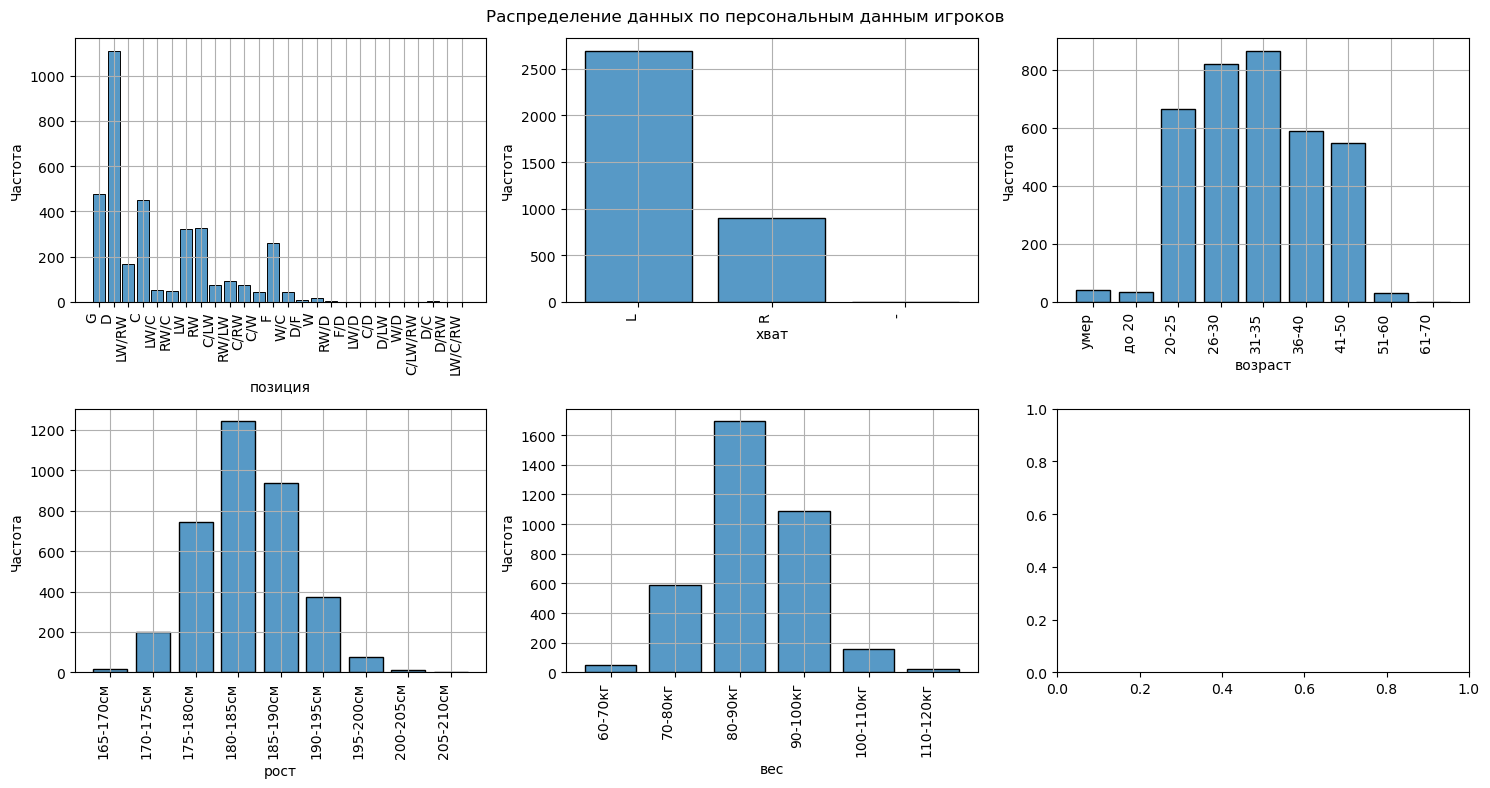

In [ ]:
cols = ['position', 'grip', 'age_period', 'height_range','weight_range']
titles = ['позиция','хват','возраст','рост','вес']
fig, axs = plt.subplots(2,3, figsize=(15, 8))
for i, ax in enumerate(axs.flat):
    if i < 5:
        sns.histplot(pl_p_d[cols[i]], ax=ax,shrink=0.8, discrete=True)
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
        ax.grid(True)
        ax.set_xlabel(titles[i])
        ax.set_ylabel('Частота')
    else:
        break
plt.suptitle('Распределение данных по персональным данным игроков')
plt.tight_layout()

1. Позиция - больше всего игроков с позициями D, G, C, LW, RW, F
2. Хват в основном левый
3. Возраст - пик в 31-35 лет
4. Рост - пик 180-185 см
5. Вес - пик - 80-90 кг

Сконвертируем стобец date в датасете с переходами из строки в формат даты:

In [ ]:
pl_trans['date'] = pd.to_datetime(pl_trans['date'], format='%d/%m/%Y')

### Расчет числа Лемтюгова

Для расчета числа Лемтюгова нам нужно получит датасет, в котором будут все игроки <br>
с "одной" стороны и их одноклубники с "другой".  При этом одноклубниками могут <br>
считаться только игравшие вместе в один временной период. Исходя из этого и будем<br>
формировать нужный датасет:

Посмотрим в каких командах и когда играл Лемтюгов:

In [ ]:
pl_trans = pl_trans.sort_values(by='date')

In [ ]:
pl_trans.query('player=="Nikolai Lemtyugov"')

,date,player,from_team,to_team,player_id,from_team_id,to_team_id
163469,2010-01-14,Nikolai Lemtyugov,Severstal Cherepovets,Ak Bars Kazan,9263,198.0,184.0
150468,2011-11-04,Nikolai Lemtyugov,Ak Bars Kazan,Metallurg Magnitogorsk,9263,184.0,193.0
149627,2011-12-30,Nikolai Lemtyugov,Metallurg Magnitogorsk,Neftekhimik Nizhnekamsk,9263,193.0,196.0
146692,2012-05-29,Nikolai Lemtyugov,Neftekhimik Nizhnekamsk,Atlant Mytishchi,9263,196.0,1572.0
140608,2012-12-29,Nikolai Lemtyugov,Atlant Mytishchi,Traktor Chelyabinsk,9263,1572.0,1679.0
137261,2013-05-22,Nikolai Lemtyugov,Traktor Chelyabinsk,Sibir Novosibirsk,9263,1679.0,1003.0
130319,2013-12-09,Nikolai Lemtyugov,Sibir Novosibirsk,Spartak Moskva,9263,1003.0,775.0
124384,2014-07-11,Nikolai Lemtyugov,Spartak Moskva,Avangard Omsk,9263,775.0,186.0
118887,2014-12-25,Nikolai Lemtyugov,Avangard Omsk,Yugra Khanty-Mansiysk,9263,186.0,2870.0
112617,2015-07-10,Nikolai Lemtyugov,Yugra Khanty-Mansiysk,Avangard Omsk,9263,2870.0,186.0


Лемтюгов за свою карьеру играл в 12 командах <br>
Причем две последние не входят в КХЛ


Добавим столбец 'team' в датасет с переходами игроков:

In [ ]:
pl_trans['team'] = pl_trans['to_team']

In [ ]:
pl_trans = pl_trans.sort_values(by=['player', 'date'])

In [ ]:
pl_trans

,date,player,from_team,to_team,player_id,from_team_id,to_team_id,team
54179,2019-08-24,A.J. Bailey,Tottenham Steam,Waldorf Univ.,643032,17213.0,2689.0,Waldorf Univ.
59618,2019-05-22,A.J. Belanger,Calgary Northstars U18 AAA,Olds Grizzlys,413056,3569.0,2101.0,Olds Grizzlys
48345,2020-03-17,A.J. Bella,Connecticut RoughRiders,Manhattanville College,391729,12373.0,1944.0,Manhattanville College
94245,2016-11-24,A.J. Boldon,No team,Allen Americans,494065,NaN,4558.0,Allen Americans
81592,2017-10-13,A.J. Campbell,Timmins Rock,Huntsville Otters,326453,18748.0,3221.0,Huntsville Otters
...,...,...,...,...,...,...,...,...
30461,2021-07-04,Étienne Tremblay-Mathieu,Gatineau Flames,Cégep Beauce-Appalaches Condors,572386,1548.0,28415.0,Cégep Beauce-Appalaches Condors
62543,2019-03-16,Étienne Verrette,Québec Remparts,Univ. of Québec-Trois-Rivières,354274,888.0,1816.0,Univ. of Québec-Trois-Rivières
68544,2018-09-03,Örs Adorjan,Györi ETO HC U20,Fehérvár AV19 U20,294675,24025.0,5700.0,Fehérvár AV19 U20
59935,2019-05-16,Örs Adorjan,Fehérvár AV19 U20,SC Csíkszereda,294675,5700.0,2759.0,SC Csíkszereda


Добавим стобец 'start_date' (начало игры в команде):

In [ ]:
pl_trans['start_date'] = pl_trans['date']

Добавим столбец 'end_date' (дату окончания выступлений за команду):

In [ ]:
pl_trans = pl_trans.assign(end_date = pl_trans.groupby('player')['date'].shift(-1))

In [ ]:
pl_trans = pl_trans.sort_values(by='to_team_id')

Удалим строки из датасета с переходами, в которых отсутствует команда перехода, <br>
из строки мы уже взяли то нужно и теперь она не нужна

In [ ]:
pl_trans.dropna(subset=['to_team_id'], inplace=True)

In [ ]:
pl_trans.head()

,date,player,from_team,to_team,player_id,from_team_id,to_team_id,team,start_date,end_date
128977,2014-02-05,Michael Nylander,HC Vita Hästen,AIK,693,322.0,1.0,AIK,2014-02-05,NaT
13444,2022-08-07,Erik Flood,Kristianstads IK,AIK,99862,333.0,1.0,AIK,2022-08-07,2023-04-24
32131,2021-06-02,Pavel Khomchenko,Khimik Voskresensk,AIK,123118,935.0,1.0,AIK,2021-06-02,2022-06-29
91624,2017-03-29,Erik Källgren,IK Oskarshamn,AIK,142236,31.0,1.0,AIK,2017-03-29,2019-03-29
139161,2013-03-19,Marcus Nilsson,BIK Karlskoga,AIK,16958,25.0,1.0,AIK,2013-03-19,2013-04-17


Таким образом, мы получили датасет с переходами из одной команды в другую с датами<br>
выступлений (начало и конец) за новую команду. Так где нет перехода в новую команду<br>
записи удалялись - игрок перестал выступать.

In [ ]:
pl_d.head()

,team,season,player,player_number,position,captain,born,birthplace,age,height,weight,stick,player_id
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555
1,Salavat Yulaev Ufa,2008-2009,Rafael Khakimov,31,G,NaN,1990,"Ufa, RUS",33.0,180,78,L,47547
2,Salavat Yulaev Ufa,2008-2009,Vadim Tarasov,1,G,NaN,1976,"Ust-Kamenogorsk, KAZ",46.0,183,84,L,11990
3,Salavat Yulaev Ufa,2008-2009,Alexander Yeryomenko,30,G,NaN,1980,"Moskva, RUS",43.0,180,78,L,12286
4,Salavat Yulaev Ufa,2008-2009,Miroslav Blatak,23,D,NaN,1982,"Zlin, CZE",41.0,180,78,L,8421


объеденим дата сет с игроками с самим собой по полям команда и сезон и получим<br>
списки команд по сезонам без учета внутрисезонных переходов:

In [ ]:
co_players = pl_d.merge(pl_d, on=['team', 'season'])

In [ ]:
co_players.head()

,team,season,player_x,player_number_x,position_x,captain_x,born_x,birthplace_x,age_x,height_x,weight_x,stick_x,player_id_x,player_y,player_number_y,position_y,captain_y,born_y,birthplace_y,age_y,height_y,weight_y,stick_y,player_id_y
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555,Rafael Khakimov,31,G,NaN,1990,"Ufa, RUS",33.0,180,78,L,47547
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555,Vadim Tarasov,1,G,NaN,1976,"Ust-Kamenogorsk, KAZ",46.0,183,84,L,11990
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555,Alexander Yeryomenko,30,G,NaN,1980,"Moskva, RUS",43.0,180,78,L,12286
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,31,G,NaN,1982,"St. Petersburg, RUS",40.0,180,78,L,19555,Miroslav Blatak,23,D,NaN,1982,"Zlin, CZE",41.0,180,78,L,8421


оставим, только нужные столбцы чтобы не утяжелять таблицу:

In [ ]:
co_players_cut = co_players[['team','season','player_x','player_id_x','player_y','player_id_y']]

Посмотрим, что получилось:

In [ ]:
co_players_cut

,team,season,player_x,player_id_x,player_y,player_id_y
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Sergei Belov,19555
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Rafael Khakimov,47547
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Vadim Tarasov,11990
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Alexander Yeryomenko,12286
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Miroslav Blatak,8421
...,...,...,...,...,...,...
554445,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,Nikita Tochitsky,75331
554446,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,Artur Tyanulin,266824
554447,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,Dmitri Utkin,561884
554448,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,Tigran Yarulin,652831


объеденим полученный датасет с данными по игрокам без учета внутрисезонных переходов<br>
с датасетом по переходам игроков - таким образом мы сможем решить вопрос внутрисезонных<br>
переходов. Это первый этап - собираем всю информацию по "игроку х" (левая часть)

In [ ]:
co_players_full = co_players_cut.merge(pl_trans, left_on=['team', 'player_id_x'], right_on=['team', 'player_id'], how='left')

In [ ]:
co_players_full.head()

,team,season,player_x,player_id_x,player_y,player_id_y,date,player,from_team,to_team,player_id,from_team_id,to_team_id,start_date,end_date
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Sergei Belov,19555,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Rafael Khakimov,47547,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Vadim Tarasov,11990,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Alexander Yeryomenko,12286,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Miroslav Blatak,8421,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


оставим только нужные столбцы:

In [ ]:
co_players_full = co_players_full[['team', 'season','player_x', 'player_id_x', 'player_y','player_id_y',
                                   'player_y', 'start_date','end_date']]

In [ ]:
co_players_full.head()

,team,season,player_x,player_id_x,player_y,player_id_y,player_y,start_date,end_date
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Sergei Belov,19555,Sergei Belov,NaT,NaT
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Rafael Khakimov,47547,Rafael Khakimov,NaT,NaT
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Vadim Tarasov,11990,Vadim Tarasov,NaT,NaT
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Alexander Yeryomenko,12286,Alexander Yeryomenko,NaT,NaT
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,Miroslav Blatak,8421,Miroslav Blatak,NaT,NaT


переставим их в нужном порядке для удобства работы:

In [ ]:
co_players_full = co_players_full[['team', 'season','player_x', 'player_id_x','start_date', 'end_date', 'player_y', 'player_id_y']]

посмотрим что получилось:

In [ ]:
co_players_full.head()

,team,season,player_x,player_id_x,start_date,end_date,player_y,player_y,player_id_y
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Sergei Belov,Sergei Belov,19555
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Rafael Khakimov,Rafael Khakimov,47547
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Vadim Tarasov,Vadim Tarasov,11990
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Alexander Yeryomenko,Alexander Yeryomenko,12286
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Miroslav Blatak,Miroslav Blatak,8421


Начнем второй этап объединения - собираем информацию по "игроку у"(правая сторона):

In [ ]:
co_players_full = co_players_full.merge(pl_trans, left_on=['team', 'player_id_y'], right_on=['team', 'player_id'], how='left')

In [ ]:
co_players_full.head()

,team,season,player_x,player_id_x,start_date_x,end_date_x,player_y,player_y,player_id_y,date,player,from_team,to_team,player_id,from_team_id,to_team_id,start_date_y,end_date_y
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Sergei Belov,Sergei Belov,19555,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Rafael Khakimov,Rafael Khakimov,47547,2015-05-05,Rafael Khakimov,Metallurg Novokuznetsk,Salavat Yulaev Ufa,47547.0,194.0,197.0,2015-05-05,2016-05-04
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Vadim Tarasov,Vadim Tarasov,11990,2012-05-03,Vadim Tarasov,Severstal Cherepovets,Salavat Yulaev Ufa,11990.0,198.0,197.0,2012-05-03,2013-04-04
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Alexander Yeryomenko,Alexander Yeryomenko,12286,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Miroslav Blatak,Miroslav Blatak,8421,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


сохраняем только нужные столбцы:

In [ ]:
co_players_full = co_players_full[['team', 'season', 'player_x', 'player_id_x',
       'start_date_x', 'end_date_x', 'player_y',
       'player_id_y', 'start_date_y', 'end_date_y']]

In [ ]:
co_players_full.head()

,team,season,player_x,player_id_x,start_date_x,end_date_x,player_y,player_y,player_id_y,start_date_y,end_date_y
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Sergei Belov,Sergei Belov,19555,NaT,NaT
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Rafael Khakimov,Rafael Khakimov,47547,2015-05-05,2016-05-04
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Vadim Tarasov,Vadim Tarasov,11990,2012-05-03,2013-04-04
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Alexander Yeryomenko,Alexander Yeryomenko,12286,NaT,NaT
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Miroslav Blatak,Miroslav Blatak,8421,NaT,NaT


расставлем столбцы в удобном для дальнейшей работы порядке:

In [ ]:
co_players_full.columns

Index(['team', 'season', 'player_x', 'player_id_x', 'start_date_x',
       'end_date_x', 'player_y', 'player_y', 'player_id_y', 'start_date_y',
       'end_date_y'],
      dtype='object')

In [ ]:
co_players_full.columns = ['team', 'season', 'player', 'player_id', 'start_date', 'end_date','player_to_drop','co_player','co_player_id', 'co_start_date', 'co_end_date']

In [ ]:
co_players_full.drop(['player_to_drop'], axis=1, inplace=True)

In [ ]:
co_players_full

,team,season,player,player_id,start_date,end_date,co_player,co_player_id,co_start_date,co_end_date
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Sergei Belov,19555,NaT,NaT
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Rafael Khakimov,47547,2015-05-05,2016-05-04
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Vadim Tarasov,11990,2012-05-03,2013-04-04
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Alexander Yeryomenko,12286,NaT,NaT
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,NaT,NaT,Miroslav Blatak,8421,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
702854,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,2022-06-12,NaT,Nikita Tochitsky,75331,2016-10-07,2023-04-30
702855,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,2022-06-12,NaT,Artur Tyanulin,266824,2022-05-02,NaT
702856,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,2022-06-12,NaT,Dmitri Utkin,561884,NaT,NaT
702857,HK Sochi,2022-2023,Dmitri Zavgorodny,396918,2022-06-12,NaT,Tigran Yarulin,652831,NaT,NaT


Мы получили требуемый датасет, но в нем есть пропущенные значения. Заполним их на<br>
основании данных о сезонах и обычном старте и окончании сезона. Это нам понадобиться<br>
в дальнейшем для определения одноклубников переходящих из клуба в клуб во время сезона:

In [ ]:
co_players_full.loc[co_players_full['start_date'].isna(),'start_date'] = pd.to_datetime(co_players_full['season'].str.split('-').str[0] + '-08-20', format='%Y-%m-%d')
co_players_full.loc[co_players_full['end_date'].isna(),'end_date'] = pd.to_datetime(co_players_full['season'].str.split('-').str[1] + '-05-01', format='%Y-%m-%d')
co_players_full.loc[co_players_full['co_start_date'].isna(),'co_start_date'] = pd.to_datetime(co_players_full['season'].str.split('-').str[0] + '-08-20', format='%Y-%m-%d')
co_players_full.loc[co_players_full['co_end_date'].isna(),'co_end_date'] = pd.to_datetime(co_players_full['season'].str.split('-').str[1] + '-05-01', format='%Y-%m-%d')

In [ ]:
co_players_full.query('player=="Nikolai Lemtyugov"')

,team,season,player,player_id,start_date,end_date,co_player,co_player_id,co_start_date,co_end_date
23205,Severstal Cherepovets,2008-2009,Nikolai Lemtyugov,9263,2008-08-20,2009-05-01,Dmitri Shamygin,124633,2008-08-20,2009-05-01
23206,Severstal Cherepovets,2008-2009,Nikolai Lemtyugov,9263,2008-08-20,2009-05-01,Rastislav Stana,4258,2008-08-20,2009-05-01
23207,Severstal Cherepovets,2008-2009,Nikolai Lemtyugov,9263,2008-08-20,2009-05-01,Alexander Viyukhin,14605,2008-08-20,2009-05-01
23208,Severstal Cherepovets,2008-2009,Nikolai Lemtyugov,9263,2008-08-20,2009-05-01,Yuri Alexandrov,9297,2008-08-20,2009-05-01
23209,Severstal Cherepovets,2008-2009,Nikolai Lemtyugov,9263,2008-08-20,2009-05-01,Maxim Chudinov,11858,2008-08-20,2009-05-01
...,...,...,...,...,...,...,...,...,...,...
441148,Avangard Omsk,2017-2018,Nikolai Lemtyugov,9263,2015-07-10,2018-10-17,Andrei Stas,20190,2017-07-07,2021-05-05
441149,Avangard Omsk,2017-2018,Nikolai Lemtyugov,9263,2014-07-11,2014-12-25,Johan Sundström,16727,2017-05-25,2018-09-09
441150,Avangard Omsk,2017-2018,Nikolai Lemtyugov,9263,2015-07-10,2018-10-17,Johan Sundström,16727,2017-05-25,2018-09-09
441151,Avangard Omsk,2017-2018,Nikolai Lemtyugov,9263,2014-07-11,2014-12-25,Dmitri Zhukenov,277804,2017-06-27,2018-12-08


Напишем функцию для определения в объединенном датасете игроков, которые играли месте<br>
в одной команде в одно время, с учетом внутрисезонных переходов:

In [ ]:

def is_co_players(row):
    if row['start_date'] >= row['co_start_date'] and row['start_date'] <= row['co_end_date']:
        return True
    elif row['co_start_date'] >= row['start_date'] and row['co_start_date'] <= row['end_date']:
        return True
    elif row['end_date'] >= row['co_start_date'] and row['end_date'] <= row['co_end_date']:
        return True
    elif row['co_end_date'] >= row['start_date'] and row['co_end_date'] <= row['end_date']:
        return True
    else:
        return False


добавим в объединенный датасет новый столбец с информацией являются ли два <br>
игрока членами одной команды в одно время (Да/Нет):

In [ ]:
co_players_full['is_co_players'] = co_players_full.apply(is_co_players, axis=1)

In [ ]:
co_players_full.shape

(702859, 11)

In [ ]:
co_players_full.head()

,team,season,player,player_id,start_date,end_date,co_player,co_player_id,co_start_date,co_end_date,is_co_players
0,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Sergei Belov,19555,2008-08-20,2009-05-01,True
1,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Rafael Khakimov,47547,2015-05-05,2016-05-04,False
2,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Vadim Tarasov,11990,2012-05-03,2013-04-04,False
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Alexander Yeryomenko,12286,2008-08-20,2009-05-01,True
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Miroslav Blatak,8421,2008-08-20,2009-05-01,True


оставим в датасете только одноклубников - is_co_players=True и без дублирования игроков:

In [ ]:
co_players_full = co_players_full.query('(is_co_players==True) and (player_id!=co_player_id)')

In [ ]:
co_players_full.head()

,team,season,player,player_id,start_date,end_date,co_player,co_player_id,co_start_date,co_end_date,is_co_players
3,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Alexander Yeryomenko,12286,2008-08-20,2009-05-01,True
4,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Miroslav Blatak,8421,2008-08-20,2009-05-01,True
5,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Mikhail Chernov,18447,2008-08-20,2009-05-01,True
6,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Pavel Doronin,15169,2008-08-20,2009-05-01,True
7,Salavat Yulaev Ufa,2008-2009,Sergei Belov,19555,2008-08-20,2009-05-01,Sergei Klimentyev,16737,2008-08-20,2009-05-01,True


In [ ]:
co_players_full.shape

(511860, 11)

В нашей итоговой таблице 11 столбцов и 511860 строк, содержащих информацию об одноклубниках.

Подготовим данную таблицу для использования в графах:
1. сгруппируем всех игроков по значению в колонке player

In [ ]:
c = co_players_full.groupby(['player', 'player_id'])['co_player_id'].nunique().sort_values(ascending=False)

переименуем столбцы чтобы было удобно работать с ними

In [ ]:
c = c.reset_index().rename(columns={'co_player_id':'co_player_qty'})
c = c[['player_id', 'player','co_player_qty']]

оставим только столбцы нужные для создания графа

In [ ]:
one_team = co_players_full[['player_id','co_player_id']]
one_team

,player_id,co_player_id
3,19555,12286
4,19555,8421
5,19555,18447
6,19555,15169
7,19555,16737
...,...,...
702853,396918,339507
702854,396918,75331
702855,396918,266824
702856,396918,561884


Для каждого игрока создадим список с игроками, с которыми ему довелось играть:

In [ ]:
one_team_dict = one_team.groupby('player_id', as_index=False).agg({'co_player_id':'unique'})

In [ ]:
one_team_dict

,player_id,co_player_id
0,18,"[3206, 11876, 12447, 708, 43800, 95502, 9251, ..."
1,30,"[18754, 21621, 544, 14833, 86175, 38823, 8677,..."
2,41,"[322839, 265727, 10475, 85748, 274799, 9553, 2..."
3,59,"[10875, 14584, 559, 9261, 9581, 16728, 19387, ..."
4,65,"[33056, 13476, 9571, 500, 18108, 6497, 8663, 4..."
...,...,...
3594,707284,"[16733, 192207, 215320, 627118, 700146, 19767,..."
3595,708561,"[105818, 14586, 353321, 519762, 309541, 20523,..."
3596,708989,"[398156, 10475, 20050, 392164, 34767, 43977, 3..."
3597,709006,"[34768, 398156, 20050, 100449, 33754, 45972, 4..."


Подготовим датасет для использования в графах, по сути это уже и будет граф:

In [ ]:
graph = {a : b for a, b in one_team_dict.values}
graph

{18: array([ 3206, 11876, 12447,   708, 43800, 95502,  9251,  9249, 23857,
         9485, 13653, 15839, 66016,  8592, 17721, 10608,  9634, 11598,
        94946, 12404, 17727,  9612, 19372,  9665, 11850, 26564, 27294,
        95703,   666, 28774, 22961, 11772]),
 30: array([ 18754,  21621,    544,  14833,  86175,  38823,   8677,  11395,
         34094,   9915,  38061,   8961,   2561,  32727,  87930,  98212,
         24598,   9472,  10235,  11507,  13627,  10371,  16833, 152219,
          8640,  22578, 185643,  14856, 106901,   7558, 187500,   9622,
         16872]),
 41: array([322839, 265727,  10475,  85748, 274799,   9553, 211104,  41338,
         11404,  84480,   9580,  26448,  38656,  40998,  16748,  11862,
        103317,  42338, 123059, 250349, 131756, 266241,  42137,  93875,
        218101,  77194,  19413,  45662,   9615,  12250,  37363,  20550,
          9563,  19034,  18078, 103312, 168682, 300957,  15184,  91217,
         34771, 326707,   9576, 123080,  99489,   8522, 313027, 

Напишем функцию для поиска числа Лемтюгова, здесь используется алгоритм поиска<br>
в графе в ширину(bfs)

In [ ]:
def lem_num(graph, start):
    visited, queue = set(), collections.deque()
    queue.append((start, 0))
    lem_num = {}
    visited.add(start)
    while queue:
        cur_player, level = queue.popleft()
        lem_num[cur_player] = level
        for co_player in graph[cur_player]:
            if co_player not in visited:
                visited.add(co_player)
                queue.append((co_player, level + 1))
    return lem_num



Рассчитаем число Лемтюгова для Николая Лемтюгова:

In [ ]:
stats = lem_num(graph, 9263)
stats[max(stats, key=lambda key: stats[key])]


3

Число равно 3, т.е. любого игрока в КХЛ "отделяет" от Лемтюгова 3 "рукопожатия"

Найдем число Лемтюгова для всех игроков, для каждого свое:

In [ ]:
from tqdm import tqdm
lem_dic = {}
for i in tqdm(one_team_dict['player_id']):
    st = lem_num(graph, i)
    ln = st[max(st, key=lambda key: st[key])]
    lem_dic[i] = ln

  0%|          | 1/3599 [00:00<06:40,  8.98it/s]

100%|██████████| 3599/3599 [04:16<00:00, 14.02it/s]


In [ ]:
lem_dic[9263]

3

In [ ]:
# Код ревьюера - преобразуем словарь в датафрейм
lem_info = pd.DataFrame.from_dict(stats, orient='index').reset_index().rename(columns={'index': 'id', 0: 'number'})
lem_info

,id,number
0,9263,0
1,124633,1
2,4258,1
3,14605,1
4,9297,1
...,...,...
3594,288275,3
3595,19361,3
3596,31383,3
3597,498730,3


создадим датафрейм с информацией о числах Лемтюгова для игроков КХЛ:

In [ ]:
col_info = pd.DataFrame.from_dict(lem_dic, orient='index').rename(columns={'index': 'id', 0: 'lemtyugov_number'})

In [ ]:
col_info.head(10)

,lemtyugov_number
18,4
30,4
41,4
59,3
65,4
67,4
75,4
92,4
97,4
116,4


посмотрим, как распределяются игороки по числам Лемтюгова:

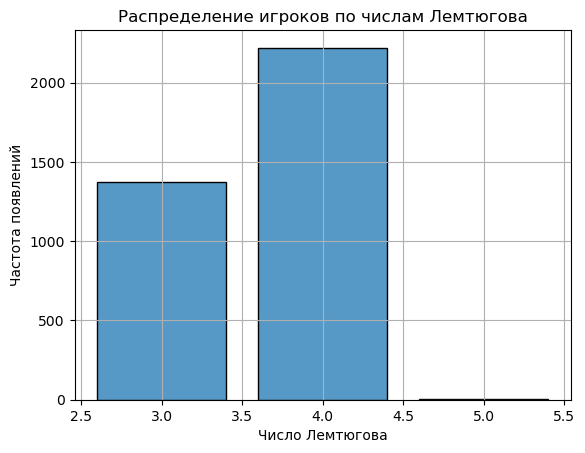

In [ ]:
sns.histplot(col_info['lemtyugov_number'], bins=10, shrink=0.8, discrete=True)
plt.title('Распределение игроков по числам Лемтюгова')
plt.xlabel('Число Лемтюгова')
plt.ylabel('Частота появлений')
plt.grid(True)
plt.show()

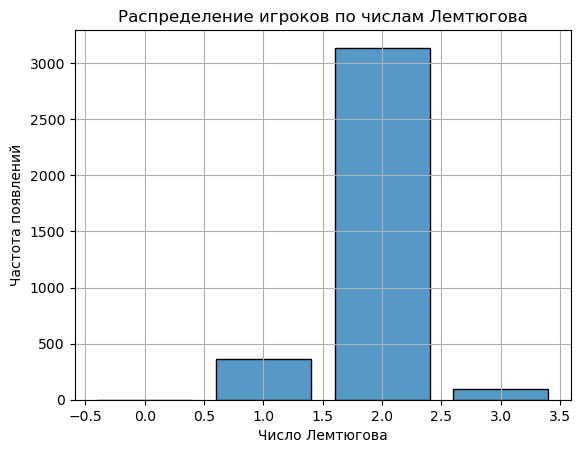

In [ ]:
#Код ревьюера - перестроим график с распределением значения числа
sns.histplot(lem_info['number'], bins=3, shrink=0.8, discrete=True)
plt.title('Распределение игроков по числам Лемтюгова')
plt.xlabel('Число Лемтюгова')
plt.ylabel('Частота появлений')
plt.grid(True)
plt.show()

Посмотрим, а не являются ли 5-ки выбросом?

In [ ]:
np.percentile(col_info['lemtyugov_number'], [95, 99])

array([4., 4.])

из полученного результата видно, что 99% игроков имеют число Лемтюгова не выше 4.
Значит число 5 можно принять за выброс.

Подведем итог: Большинство игроков имеют число Лемтюгова 3 или 4(больше всего) - 99%.<br>
Значение числа Лемтюгова 5 можно считать выбросом. Сам Николай Лемтюгов имеет значение 3.

Посмотрим, чем еще отличаются группы игроков кроме числа Люмтюгова. Берем кластеры<br>
с 3-ми и 4-ми. Другими словами, что еще может объединять игроков в кластеры по числу<br>
Лемтюгова

подготовим датасет с именами игроков и их идентификаторами:

In [ ]:
pl_names = co_players_full.groupby(['player_id', 'player'], as_index=False).agg({'co_player':'count'})
pl_names = pl_names[['player_id', 'player']]
pl_names.index = pl_names['player_id']
pl_names = pl_names.drop(columns='player_id')

объединим датасеты с именами игроков и их числами Лемтюгова:

In [ ]:
col_info = pl_names.join(col_info)

In [ ]:
col_info['lemtyugov_number'].unique()

array([4, 3, 5])

In [ ]:
col_info = col_info.reset_index()

In [ ]:
pl_p_d.columns

Index(['player_name', 'date_of_birth', 'position', 'age', 'place_of_birth',
       'nation', 'grip', 'youth_team', 'height_cm', 'weight_kg', 'awards',
       'player_id', 'age_period', 'height_range', 'weight_range'],
      dtype='object')

In [ ]:
pl_p_d = pl_p_d.drop(columns='player_name')

объеденим датасеты с числами Лемтюгова и персональными данными игроков:

In [ ]:
tmp3 = col_info.merge(pl_p_d, how='left', on='player_id')

In [ ]:
tmp3['lemtyugov_number'] = tmp3['lemtyugov_number'].astype(str)

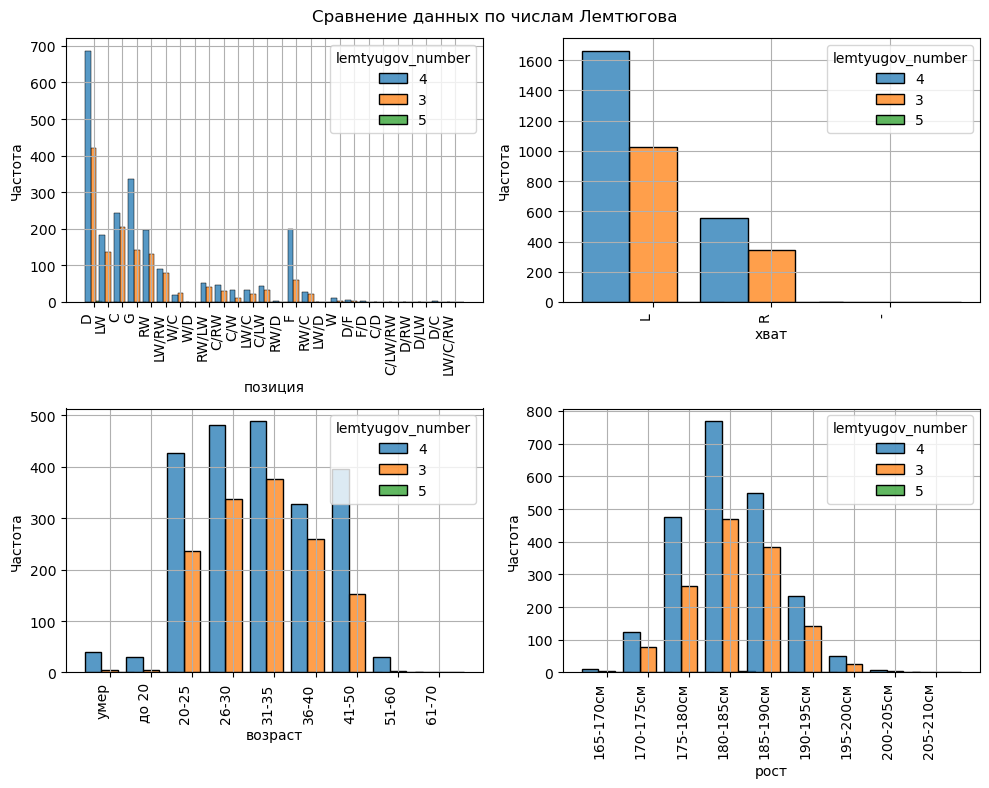

In [ ]:
colms = ['position', 'grip', 'age_period', 'height_range','weight_range']
titles = ['позиция','хват','возраст','рост','вес']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flat):
    if i < 4:
        sns.histplot(data=tmp3, x=colms[i], ax=ax,hue='lemtyugov_number',shrink=1.2, multiple='dodge')
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
        ax.grid(True)
        ax.set_xlabel(titles[i])
        ax.set_ylabel('Частота')
    else:
        break
plt.suptitle('Сравнение данных по числам Лемтюгова')
plt.tight_layout()

Из всех графиков только возраст показывает какую-то зависимость - мы видим, что<br>
чем ближе возраст игроков к возрасту Лемтюгова(37 лет) тем меньше разница между <br>
значениями 3 и 4, а чем дальше, тем разница больше

### Анализ полученного датасета с помощью графов

создадим экземпляр класса граф:

In [ ]:
G = nx.Graph()

наполним экземпляр информацией о ребрах графа, т.о зададим реальный граф:

In [ ]:
G.add_edges_from(one_team.to_records(index=False))

узнеам кол-во вершин графа:

In [ ]:
G.number_of_nodes()

3599

Всего вершин 3599.

Уточним кол-во ребер:

In [ ]:
G.number_of_edges()

179868

кол-во ребер равно 179`868

#### Коэффициент кластеризации

Коэф. кластеризации. является мерой степени, с которой узлы графа имеют<br>
тенденцию группироваться вместе.

In [ ]:
clus_coef = nx.clustering(G)
clus_coef = convert_to_df(clus_coef, 'clust_coef')
col_info = col_info.join(clus_coef)

Посмотрим на 20 игроков имеющих максимальное значение коэффициента кластеризации:

In [ ]:
col_info.sort_values(by=['clust_coef'],
                     ascending=False).head(20).style.background_gradient(subset=[
                                                                'clust_coef'],
                                                                low=0, high=1)

,player_id,player,lemtyugov_number,clust_coef
2677,212429,Maxim Kapiturov,3,1.000000
182,5877,Mikko Lehtonen,4,1.000000
512,9583,Dmitri Shitikov,3,1.000000
2368,107355,Nikita Glotov,3,1.000000
500,9568,Alexei Kaigorodov,4,1.000000
2569,166414,Christián Pavlas,4,1.000000
292,8606,Shaun Heshka,4,1.000000
2627,190265,Lukas Klok,4,1.000000
2647,201450,Ivan Lodnia,4,1.000000
2670,211961,Yevgeni Petrikov,4,1.000000


#### Степень связности (degree centrality)

Степень связности (degree centrality) определяется как число связей,<br>
инцидентных узлу (то есть число связей, которое имеет узел), значение нормировано<br>
на максимальное возможное значение связности вершин графа, таким образом границы<br>
возможных значений (0, 1)


In [ ]:
df_tmp = nx.degree_centrality(G)
df_tmp = convert_to_df(df_tmp, 'degree_centrality')
col_info = col_info.join(df_tmp)

In [ ]:
df_tmp.head()

,degree_centrality
19555,0.012229
12286,0.062257
8421,0.049750
18447,0.051695
15169,0.008894


In [ ]:
col_info.sort_values(by=['degree_centrality'],
                     ascending=False).head(20).style.background_gradient(subset=[
                                                               'degree_centrality'],
                                                               low=0.1, high=0.13)

,player_id,player,lemtyugov_number,clust_coef,degree_centrality
849,13432,Matt Anderson,4,0.172588,0.116732
604,10487,Anton Glovatsky,3,0.156376,0.090884
3202,379717,Kirill Spitsenko,3,0.160128,0.083936
1295,19409,Oleg Gubin,3,0.223921,0.068093
3482,550186,Artjoms Lescenko,4,0.253879,0.060589
704,11485,Karel Pilar,4,0.257425,0.051695
2045,66012,Tomas Matousek,4,0.277093,0.050584
1288,19402,Alexander Tryanichev,3,0.303199,0.047526
543,9633,Petr Vrána,3,0.305438,0.046971
2561,164687,Yaroslav Yevdokimov,4,0.248309,0.046971


#### Степень влиятельности (eigenvector centrality)

Степень влиятельности (eigenvector centrality) - мера учитывает <br>
“влиятельность” ближайших соседей, которые вносят больше в показатель узла,<br>
чем такая же связь с узлом с низким показателем

In [ ]:
df_tmp = nx.eigenvector_centrality(G)
df_tmp = convert_to_df(df_tmp, 'eigenvector_centrality')
col_info = col_info.join(df_tmp)

In [ ]:
col_info.sort_values(by=['eigenvector_centrality'],
                     ascending=False).head(20).style.background_gradient(subset=[
                                                               'eigenvector_centrality'],
                                                               low=0.1, high=0.1)

,player_id,player,lemtyugov_number,clust_coef,degree_centrality,eigenvector_centrality
849,13432,Matt Anderson,4,0.172588,0.116732,0.061082
604,10487,Anton Glovatsky,3,0.156376,0.090884,0.037133
1295,19409,Oleg Gubin,3,0.223921,0.068093,0.033172
3482,550186,Artjoms Lescenko,4,0.253879,0.060589,0.032541
2045,66012,Tomas Matousek,4,0.277093,0.050584,0.027934
1288,19402,Alexander Tryanichev,3,0.303199,0.047526,0.026156
704,11485,Karel Pilar,4,0.257425,0.051695,0.025321
2021,58569,Roman Konkov,3,0.314120,0.041134,0.024434
3202,379717,Kirill Spitsenko,3,0.160128,0.083936,0.023291
2646,201447,Alexander Chmelevski,4,0.352912,0.039466,0.021207


#### Степень близости(closeness centrality)

Степень близости(closeness centrality) - средняя длина кратчайшего пути между узлом<br>
и всеми остальными узлами в графе. Т.о. чем меньше значение степени близости тем<br>
узел более центральный. Значение степени близости обычно нормируют на число узлов<br>
минус один и приводят итоговый результат в границы (0, 1)

In [ ]:
df_tmp = nx.closeness_centrality(G)
df_tmp = convert_to_df(df_tmp, 'closeness_centrality')
col_info = col_info.join(df_tmp)

In [ ]:
col_info.sort_values(by=['closeness_centrality']
                     ).head(20).style.background_gradient(subset=[
                                                               'closeness_centrality'],
                                                               low=0.1, high=0.1)

,player_id,player,lemtyugov_number,clust_coef,degree_centrality,eigenvector_centrality,closeness_centrality
235,7556,Anssi Salmela,4,0.982684,0.006115,0.000728,0.353299
18,229,Joakim Lindström,4,0.997984,0.008894,0.000776,0.360883
3206,379894,Alexander Petrunin,4,0.997984,0.008894,0.000776,0.360883
512,9583,Dmitri Shitikov,3,1.000000,0.009450,0.000991,0.364539
182,5877,Mikko Lehtonen,4,1.000000,0.009450,0.000991,0.364539
1140,18499,Alexei Troshchinsky,3,1.000000,0.006392,0.001426,0.365576
728,11807,Mika Järvinen,4,1.000000,0.006392,0.001426,0.365576
65,2564,Jyrki Välivaara,4,1.000000,0.006948,0.000866,0.366582
500,9568,Alexei Kaigorodov,4,1.000000,0.006948,0.000866,0.366582
2671,211962,Igor Isayev,3,0.978495,0.008616,0.001108,0.369215


#### Степень посредничества(betweenness centrality)

Степень посредничества(betweenness centrality) - вероятность оказаться на случайно <br>
выбранном кратчайшем пути между двумя случайно выбранными вершинами.<br>
В нормированном случае значения показателя находятся в границах [0, 1]

In [ ]:
df_tmp = nx.betweenness_centrality(G)


In [ ]:
df_tmp = convert_to_df(df_tmp, 'betweenness_centrality')
col_info = col_info.join(df_tmp)

In [ ]:
col_info.sort_values(by=['betweenness_centrality'],
                     ascending=False).head(20).style.background_gradient(subset=[
                                                               'betweenness_centrality'],
                                                               low=0.1, high=0.1)

,player_id,player,lemtyugov_number,clust_coef,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
3202,379717,Kirill Spitsenko,3,0.160128,0.083936,0.023291,0.497649,0.005935
604,10487,Anton Glovatsky,3,0.156376,0.090884,0.037133,0.512098,0.005511
849,13432,Matt Anderson,4,0.172588,0.116732,0.061082,0.520921,0.003215
1295,19409,Oleg Gubin,3,0.223921,0.068093,0.033172,0.502023,0.001308
2090,75331,Nikita Tochitsky,3,0.283702,0.040022,0.016887,0.466970,0.001217
2688,213653,Denis Gorbunov,3,0.268886,0.039744,0.013752,0.466364,0.001147
3187,375736,Alexei Drobin,4,0.290194,0.036409,0.010012,0.449806,0.001079
2561,164687,Yaroslav Yevdokimov,4,0.248309,0.046971,0.018746,0.478903,0.001033
2093,76146,Justin Danforth,4,0.315044,0.035853,0.011499,0.453606,0.000941
3482,550186,Artjoms Lescenko,4,0.253879,0.060589,0.032541,0.497030,0.000919


Составим датасет из 20 наиболее значимых игроков по каждому полученному при анализе графов полю (кроме числа Лемтюгова)

In [ ]:
cols = ['clust_coef','degree_centrality','eigenvector_centrality','closeness_centrality','betweenness_centrality']

for i, col in enumerate(cols):
    if i == 0:
        res_df = col_info.reset_index().nlargest(20, col)
    else:
        temp_df = col_info.reset_index().nlargest(20, col)
        res_df = pd.concat([res_df, temp_df], ignore_index=True)

In [ ]:
res_df.duplicated().sum()

53

In [ ]:
res_df = res_df.drop_duplicates()

In [ ]:
H = nx.subgraph(G, res_df['player_id'].to_list())

In [ ]:
pl = dict()
res_lst = res_df[['player_id', 'player']].apply(lambda x: list([x['player_id'],x['player']]), axis=1).to_list()
for l in res_lst:
    pl[l[0]] = l[1]

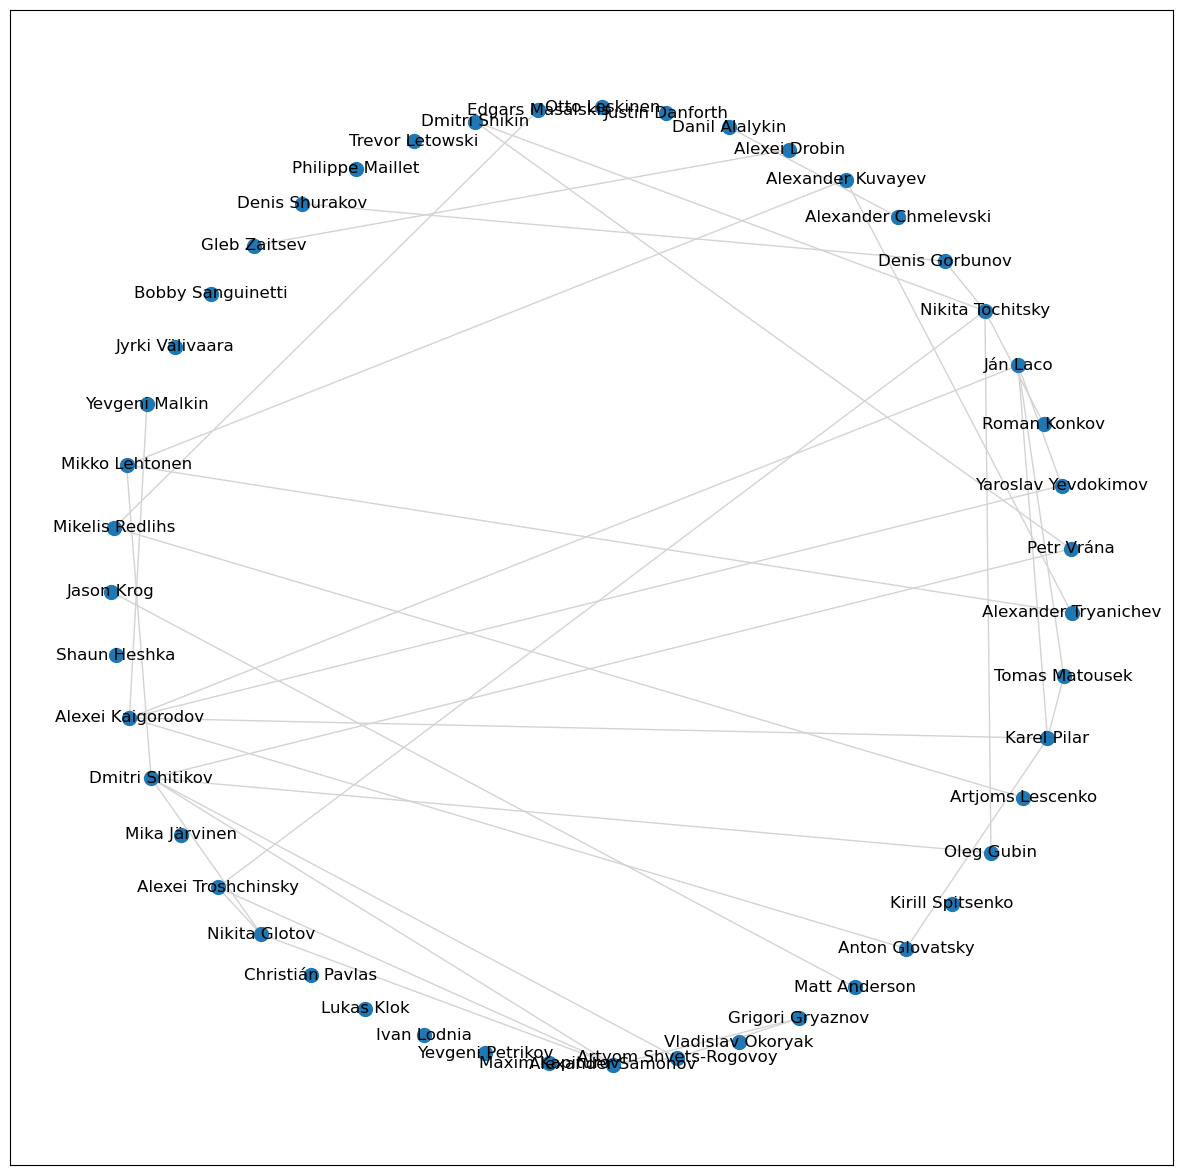

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
shells =[res_df['player_id'][:10],
         res_df['player_id'][:20],
         res_df['player_id'][:30],
         res_df['player_id'][:40],
         res_df['player_id'][:50],
         res_df['player_id'][50:]]
pos = nx.shell_layout(G, shells, scale=10)

nx.draw_networkx(H,pos,node_size=100, ax=ax, labels=pl,edge_color='lightgrey')

Мы можем заметить, что одна половина "круга" плотно покрыта ребрами графа, вторая половина<br>
более разреженная, также с разреженной стороны в основном иностранцы, с другой <br>
в основном русские игроки.

## Общие выводы

в ходе нашего исследования мы провели следующие действия:<br>
1. Загрузили и изучили данные<br>
2. Проверили их на пропуски: все найденные пропуски были оставлены как есть, так как<br>
   заполнить их не представлялось возможным. Исключение составил столбец age в котором<br>
   пропуски заменили расчитав возраст исходя из года рождения и текущего года.<br>
3. Проверили на наличие дубликатов - нашли 7 в датасете данными о переходах pl_trans<br>
   дубликаты были удалены.<br>   
4. Добавили необходимые для дальнейшего анализа столбцы:<br>
   - уникальные номера играков и команд (получили из ссылок)<br>
   - интервалы для веса, роста, возраста<br>
5. Расчитали число Лемтюгова:<br>
   - в итоге мы получили 3 числа 3, 4, 5. 99% всех игроков имеют число 3 или 4.<br>
     В связи с чем мы момжем принять, что значение 5 является выбросом.<br>
   - У николая Лемтюгова число равно 3<br>
   - Из всего кол-ва игроков значение 4 имеет большая часть - чуть меньше 65%,<br>
     и оставшиеся примерно 35% имеют значение 3
5. Мы также проанализировали датасет с использованием графов и выделили несколько<br>
   категорий игроков        